# Method 4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nn
from typing import Callable
import time
from sklearn.model_selection import train_test_split

In [90]:
def word_to_vector(word: str, substrings: list) -> np.array:
    array = np.zeros(len(substrings))
    lst = []
    for i, alph in enumerate(substrings):
        lst.append(word.count(alph))
    return np.array(lst)

def word_to_custom_vector(word: str, custom_parameters: list) -> np.array:
    word = word.lower()
    vector = np.zeros(len(custom_parameters))
    for i, parameter in enumerate(custom_parameters):
        if type(parameter) == str:
            vector[i] = word.count(parameter)
        else:
            vector[i] = parameter(word)
    return vector


CZ_ALPHABET = ['a', 'á', 'b', 'c', 'č', 'd', 'ď',
               'e', 'é', 'ě', 'f', 'g', 'h', 'ch',
               'i', 'í', 'j', 'k', 'l', 'm', 'n',
               'ň', 'o', 'ó', 'p', 'q', 'r', 'ř',
               's', 'š', 't', 'ť', 'u', 'ú','ů',
               'v', 'w', 'x', 'y', 'ý','z', 'ž']

VOWELS = ['a', 'á', 'e', 'é', 'ě', 'i', 'í', 'o', 'u', 'ú', 'ů']
CONSONANTS = list(set(CZ_ALPHABET) -  set(VOWELS))

HACKY = ['č', 'ď', 'ě', 'ň', 'ř', 'š', 'ť', 'ž']
CARKY = ['á', 'é', 'í', 'ó', 'ú', 'ů']

CUSTOM = [
    len,
    lambda x: x.count(' ') + 1,
    lambda x: sum(x.count(sub) for sub in VOWELS),
    lambda x: sum(x.count(sub) for sub in CONSONANTS),
    lambda x: sum(x.count(sub) for sub in HACKY),
    lambda x: sum(x.count(sub) for sub in CARKY),
] + CZ_ALPHABET


# set used for vectorization
SUBSTRINGS = CZ_ALPHABET

In [92]:
VECTORIZATION_FUNC = lambda x: word_to_custom_vector(x, CUSTOM)

data = pd.read_csv('data.csv', encoding = 'ansi', usecols=['Obec', 'Kraj'])
data = data[data['Obec'] != 'Praha']

data['Obec'] = data['Obec'].str.lower()

data['food'] = data['Obec'].apply(VECTORIZATION_FUNC)
data['food'] = data['food'].apply(lambda x: x / np.linalg.norm(x))

LIST_KRAJE = np.sort(data['Kraj'].unique().tolist())
data['expected'] = data['Kraj'].apply(lambda x: word_to_vector(x, LIST_KRAJE))

In [93]:
TEST_SIZE = 0.2
data_train = data.sample(frac=(1-TEST_SIZE), random_state=0)
data_test = data.drop(data_train.index)

In [94]:
%load_ext autoreload
%autoreload 2

ACT_FUNCS = [nn.sigmoid, nn.sigmoid]
ADAPTIVE_ETA = True

N_HIDDEN = 5
ETA = 1.e-2
ETA_LIMIT = 1.e-10
N_EPOCHS = 30

network_shape = (np.shape(data['food'].iloc[0])[0], N_HIDDEN, len(LIST_KRAJE))
neural_network = nn.NeuralNetwork(shape=network_shape, act_funcs=ACT_FUNCS,
                                  eta=ETA, eta_limit=ETA_LIMIT, adaptive_eta=ADAPTIVE_ETA)

# find kraj with minimum number of obce
counts = data.groupby(data['Kraj']).count()['Obec'].sort_index()
count_min, arg_count_min = counts.min(), counts.argmin()
kraj_min = LIST_KRAJE[arg_count_min]
costs, accuracies_train, accuracies_test = [], [], []

for i in range(N_EPOCHS):
    if neural_network.eta <= neural_network.eta_limit:
        print('Reached learning rate limit, convergence achieved')
        break
    count_train_min = data_train[data_train['Kraj'] == kraj_min].shape[0]
    grouping = data_train.groupby(data_train['Kraj'])
    data_train_current = grouping.apply(lambda x: x.sample(n=count_train_min, random_state=i))
    data_train_current = data_train_current.reset_index(drop=True)
    data_train_current = data_train_current.sample(frac=1, random_state=i)
    data_train_current = data_train_current[['food', 'expected']]

    st = time.time()
    cost = neural_network.perform_epoch(df=data_train_current)
    print(f'Epoch {i+1}/{N_EPOCHS} finished in {time.time() - st:.2f} seconds')
    costs.append(cost)

    accuracy_train = neural_network.accuracy(df=data_train_current[['food', 'expected']])
    accuracies_train.append(accuracy_train)

    accuracy_test = neural_network.accuracy(df=data_test[['food', 'expected']])
    accuracies_test.append(accuracy_test)

# costs = neural_network.train(df=data_train[['food', 'expected']].iloc[:2000], n_epochs=N_EPOCHS)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/30 finished in 2.05 seconds
Epoch 2/30 finished in 2.08 seconds
Epoch 3/30 finished in 2.03 seconds
Epoch 4/30 finished in 1.99 seconds
Decreasing learning rate: eta = 1.000e-03
Epoch 5/30 finished in 3.84 seconds
Epoch 6/30 finished in 2.01 seconds
Epoch 7/30 finished in 1.99 seconds
Epoch 8/30 finished in 1.95 seconds
Epoch 9/30 finished in 1.94 seconds
Epoch 10/30 finished in 1.94 seconds
Epoch 11/30 finished in 1.94 seconds
Epoch 12/30 finished in 1.96 seconds
Decreasing learning rate: eta = 1.000e-04
Decreasing learning rate: eta = 1.000e-05
Decreasing learning rate: eta = 1.000e-06
Decreasing learning rate: eta = 1.000e-07
Decreasing learning rate: eta = 1.000e-08
Decreasing learning rate: eta = 1.000e-09
Decreasing learning rate: eta = 1.000e-10
Decreasing learning rate: eta = 1.000e-11
Reached learning rate limit!
Epoch 13/30 finished in 16.05 seconds
Reached learning rate limit, con

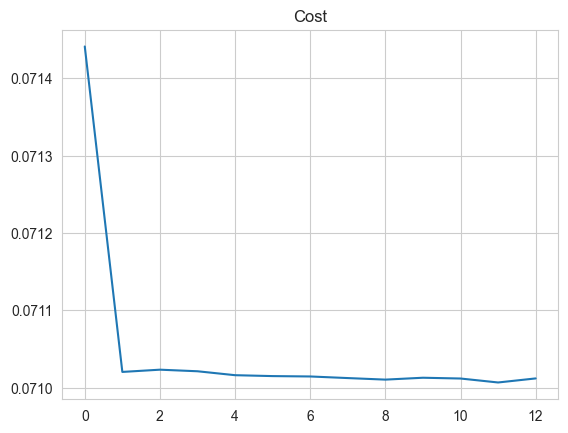

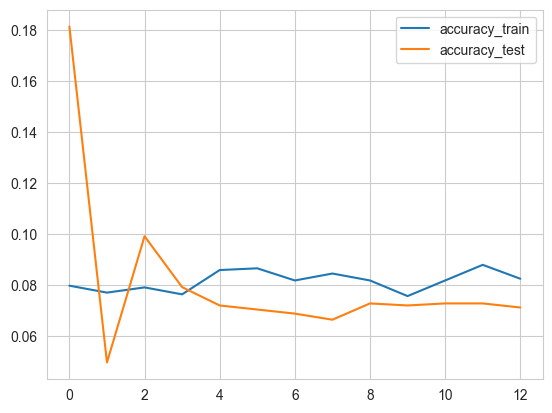

In [97]:
plt.plot(costs, label='cost')
plt.title('Cost')
plt.show()

plt.plot(accuracies_train, label='accuracy_train')
plt.plot(accuracies_test, label='accuracy_test')
plt.legend()
plt.show()

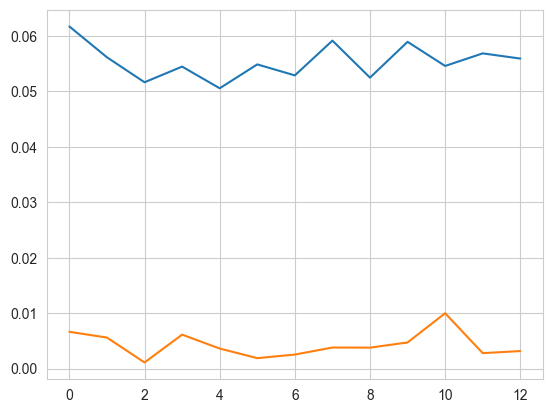

In [100]:
category_distribution = data.sort_values(by='Kraj').groupby(data['Kraj']).count()['Obec'].reset_index(drop=True) / data.shape[0]
predictions = []

for obec in data_test['Obec']:
    prediction = neural_network.predict(word_to_custom_vector(obec, custom_parameters=CUSTOM))
    predictions.append(prediction)
    # plt.plot(prediction, color='grey')

plt.plot(np.mean(predictions, axis=0))
plt.plot(category_distribution * np.mean(predictions, axis=0))
plt.show()
# plt.plot(category_distribution)

In [101]:
neural_network.accuracy(df=data_test[['food', 'expected']])

0.07108626198083066